In [1]:
import sys
import os
sys.path.append(os.path.abspath('../')) ## needed to import the function.py file
from functions import *
import pandas as pd
import plotly.express as px
import plotly.io as pio
from bertopic import BERTopic

2023-05-26 10:50:37.125520: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_feather("../../data/DataTextValidation")

In [3]:
# Load the pre-trained BERTopic model
model = BERTopic.load("../../models/BERTTopic_paraphrase-multilingual-MiniLM-L12-v2_merged.model")

# Load your dataframe with comments in a column named 'comments'
df = pd.read_feather("../../data/DataTextValidation")

# Extract the comments from the dataframe as a list
docs = df["Kommentar"].values

# Use the BERTopic model to predict the topics of the comments
topics, probs = model.transform(docs)

# Add the predicted topics to a new column in the dataframe
df['predicted_topic'] = topics

In [4]:
model_info_df = model.get_topic_info()[['Topic',"CustomName"]] # used to join custom lables in the models

In [5]:
df = df[['Kommentar','predicted_topic']]
df = df.merge(model_info_df,left_on='predicted_topic',right_on='Topic')[['Kommentar','CustomName']]
df = df.rename(columns={'CustomName': 'predicted_topic'})

In [6]:
df.predicted_topic.value_counts()

Outlier                                   136
Platzangebot Zug                           26
Pünktlichkeit                              25
Preis-Leistung                             18
Vertrieb und Services                      15
Raumtemperatur Zug                         15
WC Verfügbarkeit und Sauberkeit            12
Platzangebot Velo, Gepäck, Kinderwagen     11
Corona                                     11
Fahrplanangebot                             9
Security                                    9
Kommerzielle Angebote                       8
Sonstiges                                   7
Lob                                         6
Ausstattung Qualität Rollmaterial           4
Feedback Umfrage                            4
Sauberkeit Zug und Bahnhof                  2
Kundeninformation                           2
Internet, Wlan und Mobilfunk                2
Name: predicted_topic, dtype: int64

In [7]:
# Save the dataframe to a new file
df.to_excel('../../exports/tables/BERTTopic_paraphrase-multilingual-MiniLM-L12-v2_merged_predicted_topics.xlsx', index=False)

## Oulier reduced

In [8]:
# Load the pre-trained BERTopic model
model_outlier_reduced = BERTopic.load("../../models/BERTTopic_paraphrase-multilingual-MiniLM-L12-v2_merged_oulier_reduced.model")

# Load your dataframe with comments in a column named 'comments'
df = pd.read_feather("../../data/DataTextValidation")

# Extract the comments from the dataframe as a list
docs = df["Kommentar"].values

# Use the BERTopic model to predict the topics of the comments
topics,probs = model_outlier_reduced.transform(docs)
new_topics = model_outlier_reduced.reduce_outliers(docs, topics) # Reduce outliers
model_outlier_reduced.update_topics(docs, topics=new_topics) # update Model

# Add the predicted topics to a new column in the dataframe
df['predicted_topic'] = new_topics
#df['predicted_topic'] = topics


In [9]:
df = df[['Kommentar','predicted_topic']] # only neccecary cols
df = df.merge(model_info_df,left_on='predicted_topic',right_on='Topic')[['Kommentar','CustomName']]
df = df.rename(columns={'CustomName': 'predicted_topic'})

In [10]:
df.predicted_topic.value_counts()

Pünktlichkeit                             49
Platzangebot Zug                          40
Vertrieb und Services                     37
Preis-Leistung                            30
Lob                                       25
Sonstiges                                 21
Platzangebot Velo, Gepäck, Kinderwagen    21
Raumtemperatur Zug                        16
WC Verfügbarkeit und Sauberkeit           13
Corona                                    13
Fahrplanangebot                           13
Security                                  12
Kommerzielle Angebote                      9
Ausstattung Qualität Rollmaterial          6
Feedback Umfrage                           5
Internet, Wlan und Mobilfunk               5
Sauberkeit Zug und Bahnhof                 4
Kundeninformation                          3
Name: predicted_topic, dtype: int64

In [11]:
# Save the dataframe to a new file
df.to_excel('../../exports/tables/BERTTopic_paraphrase-multilingual-MiniLM-L12-v2_merged_predicted_topics_ouliers_reduced.xlsx', index=False)

## Calculate Accurancy Scores and create confusion Matrix

### Model 1: Without Outlier Reduction

In [87]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.colors as mcolors

def plot_confusion_matrix(df,
                          predicted_col,
                          actual_col,
                          path,
                          filename):
    """
    Plot a confusion matrix based on the provided dataframe and save it as an SVG file.
    :param df: A pandas dataframe with predicted and actual columns.
    :param predicted_col: The name of the column containing the predicted values.
    :param actual_col: The name of the column containing the actual values.
    :param path: The directory path where the SVG file will be saved.
    :param filename: The filename of the SVG file.
    """
    y_pred = df[predicted_col]
    y_true = df[actual_col]
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    fig, ax = plt.subplots(figsize=(10, 8), dpi=300)
    
    # Create a custom colormap with continuous fade to white
    cmap = mcolors.LinearSegmentedColormap.from_list("Custom", ['white', '#49787F'], N=256)
    
    sns.heatmap(cm_df, annot=True, cmap=cmap, fmt='d', cbar_kws={'label': 'Scale'})
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title("Confusion Matrix for Classification Results")
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels, rotation=0)
    
    plt.savefig(f"{path}/{filename}.svg", format='svg')
    plt.show()
    
    print(classification_report(y_true, y_pred, labels=labels))


In [88]:
# specify the path of the Excel file
file_path = '../../exports/tables/BERTTopic_paraphrase-multilingual-MiniLM-L12-v2_merged_predicted_topics_done.xlsx'
sheet_name = 'Validation'  # sheet name

# import the Excel sheet as a pandas DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

In [89]:
# path for plot export
path = '../../exports/images/'

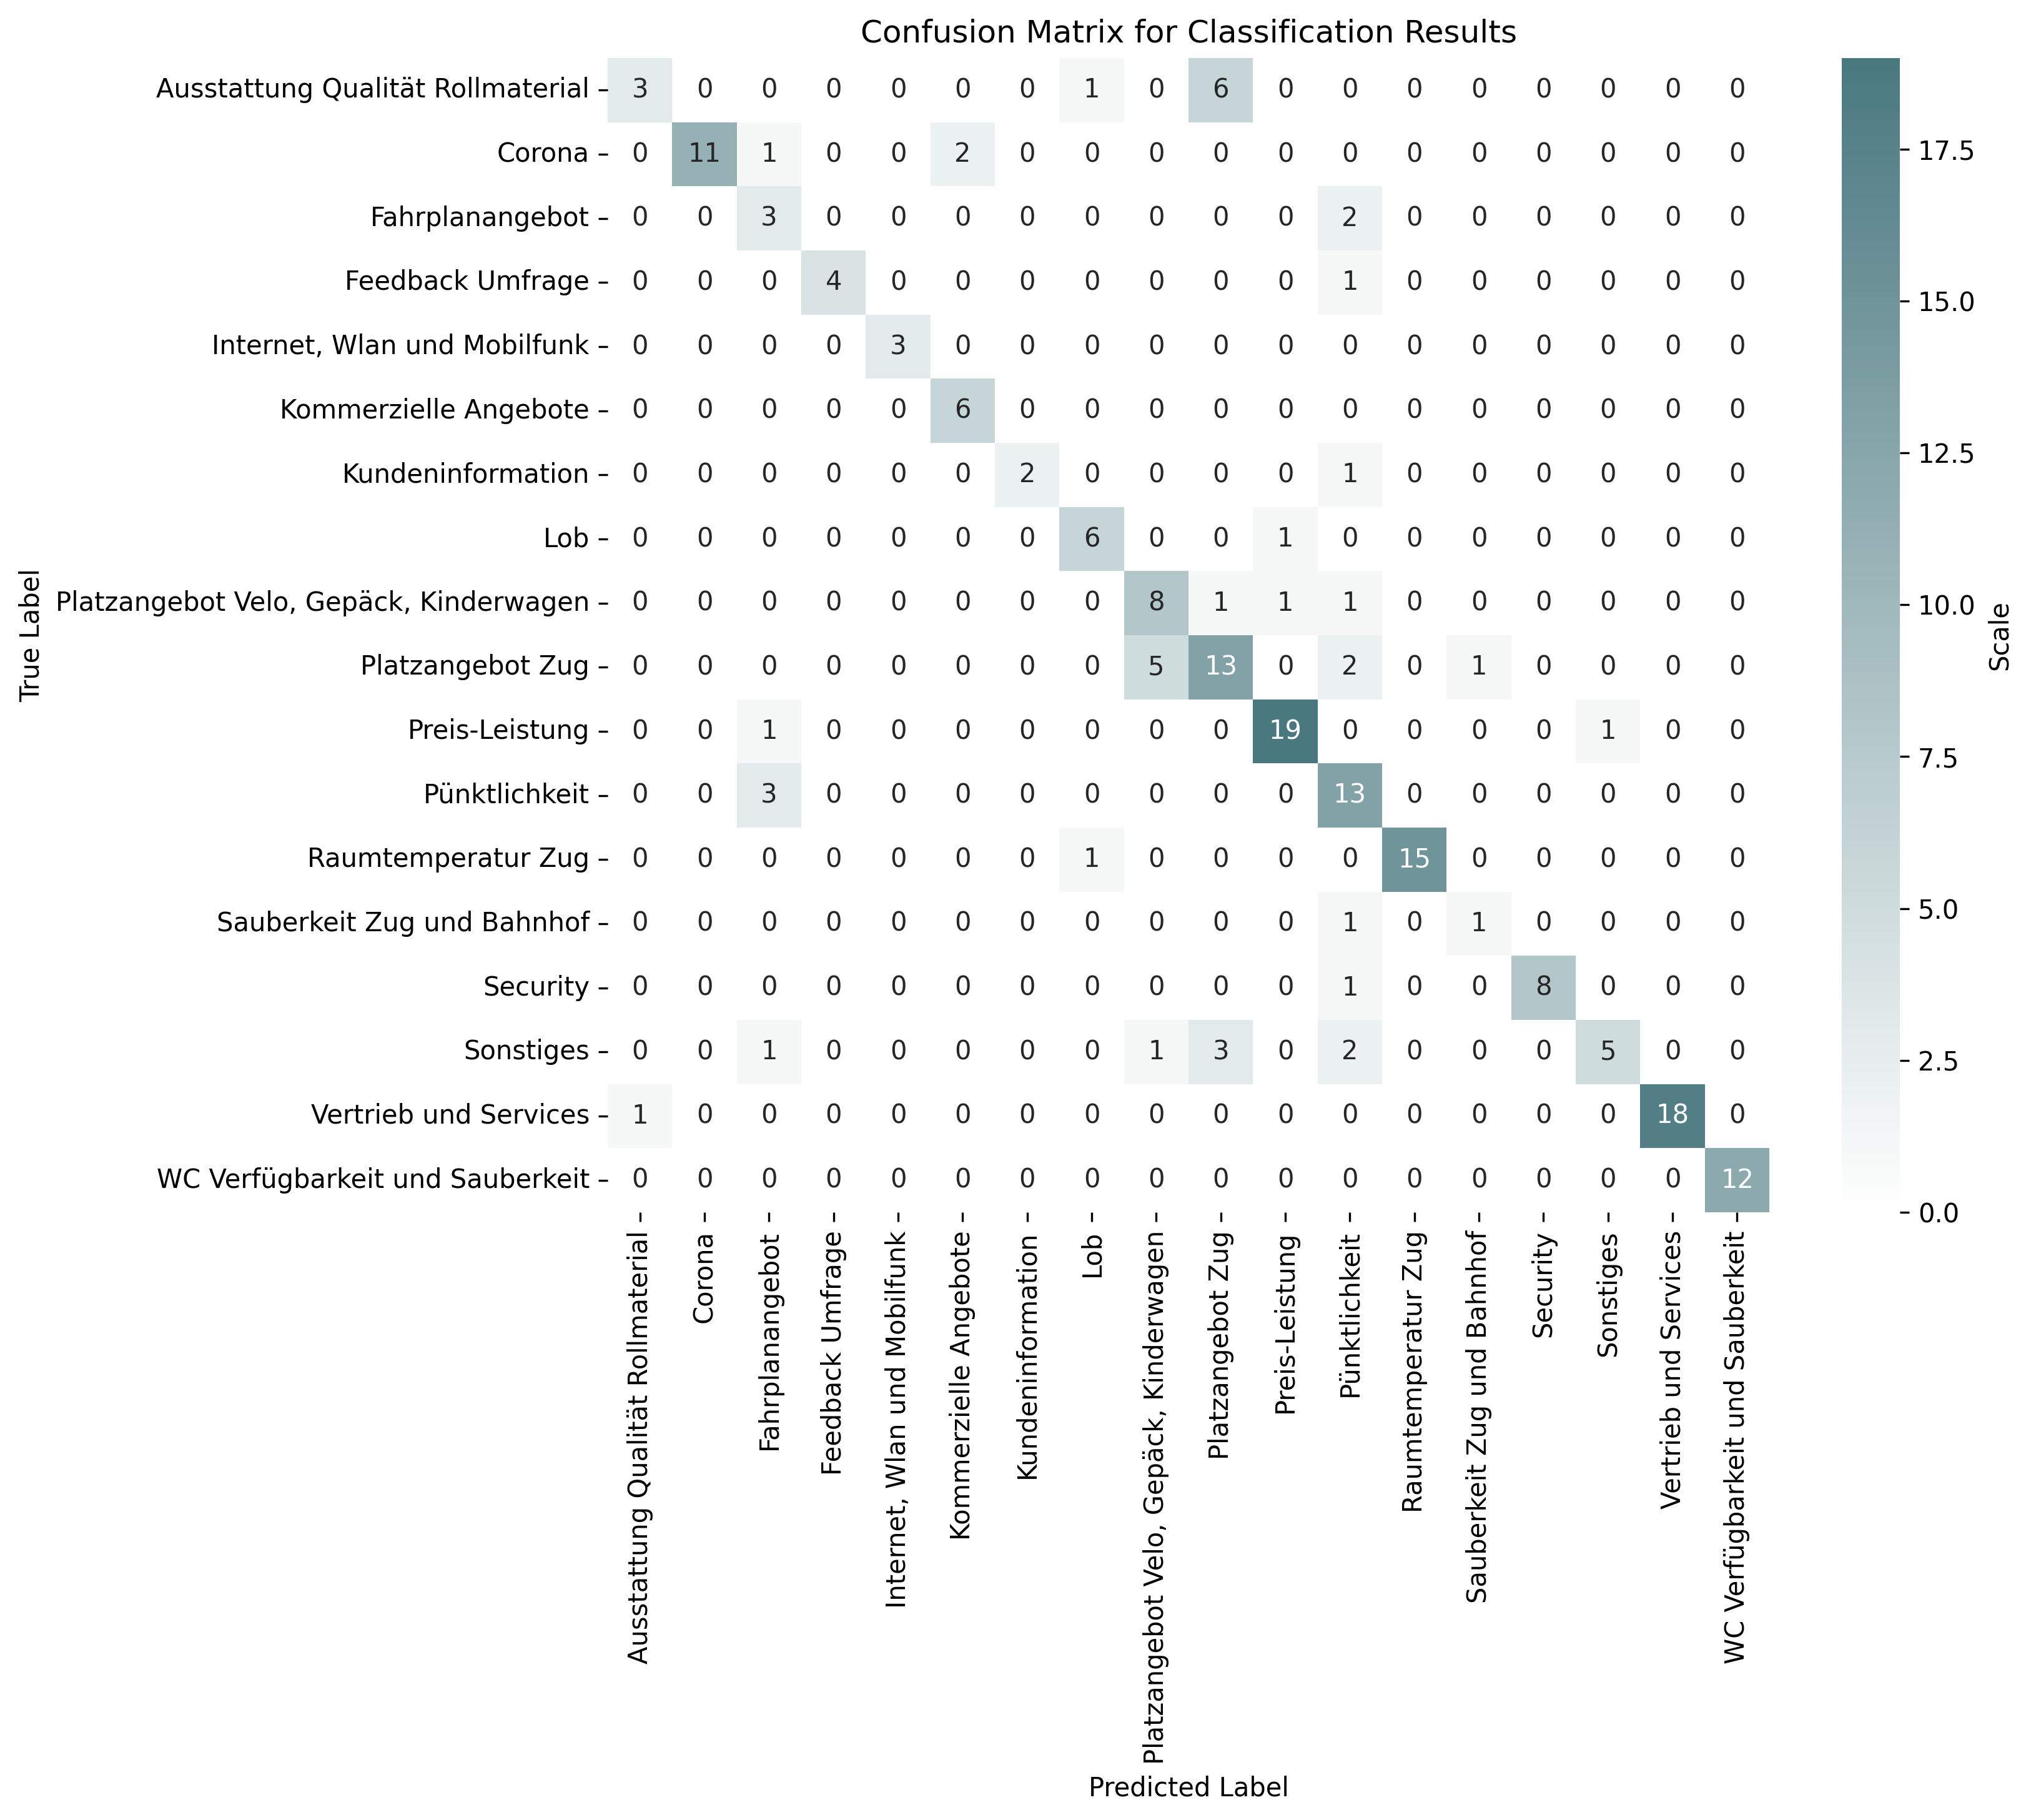

                                        precision    recall  f1-score   support

     Ausstattung Qualität Rollmaterial       0.75      0.30      0.43        10
                                Corona       1.00      0.79      0.88        14
                       Fahrplanangebot       0.33      0.60      0.43         5
                      Feedback Umfrage       1.00      0.80      0.89         5
          Internet, Wlan und Mobilfunk       1.00      1.00      1.00         3
                 Kommerzielle Angebote       0.75      1.00      0.86         6
                     Kundeninformation       1.00      0.67      0.80         3
                                   Lob       0.75      0.86      0.80         7
Platzangebot Velo, Gepäck, Kinderwagen       0.57      0.73      0.64        11
                      Platzangebot Zug       0.57      0.62      0.59        21
                        Preis-Leistung       0.90      0.90      0.90        21
                         Pünktlichkeit 

In [90]:
plot_confusion_matrix(df,
                      predicted_col='predicted_topic',
                      actual_col='real_topic',
                      path=path,
                      filename="Confusion_Matrix_CLassification_Model_1")

### Model 2: With Outlier Reduction

In [91]:
# specify the path of the Excel file
file_path = '../../exports/tables/BERTTopic_paraphrase-multilingual-MiniLM-L12-v2_merged_predicted_topics_ouliers_reduced_done.xlsx'
sheet_name = 'Validation'  # sheet name

# import the Excel sheet as a pandas DataFrame
df = pd.read_excel(file_path, sheet_name=sheet_name)

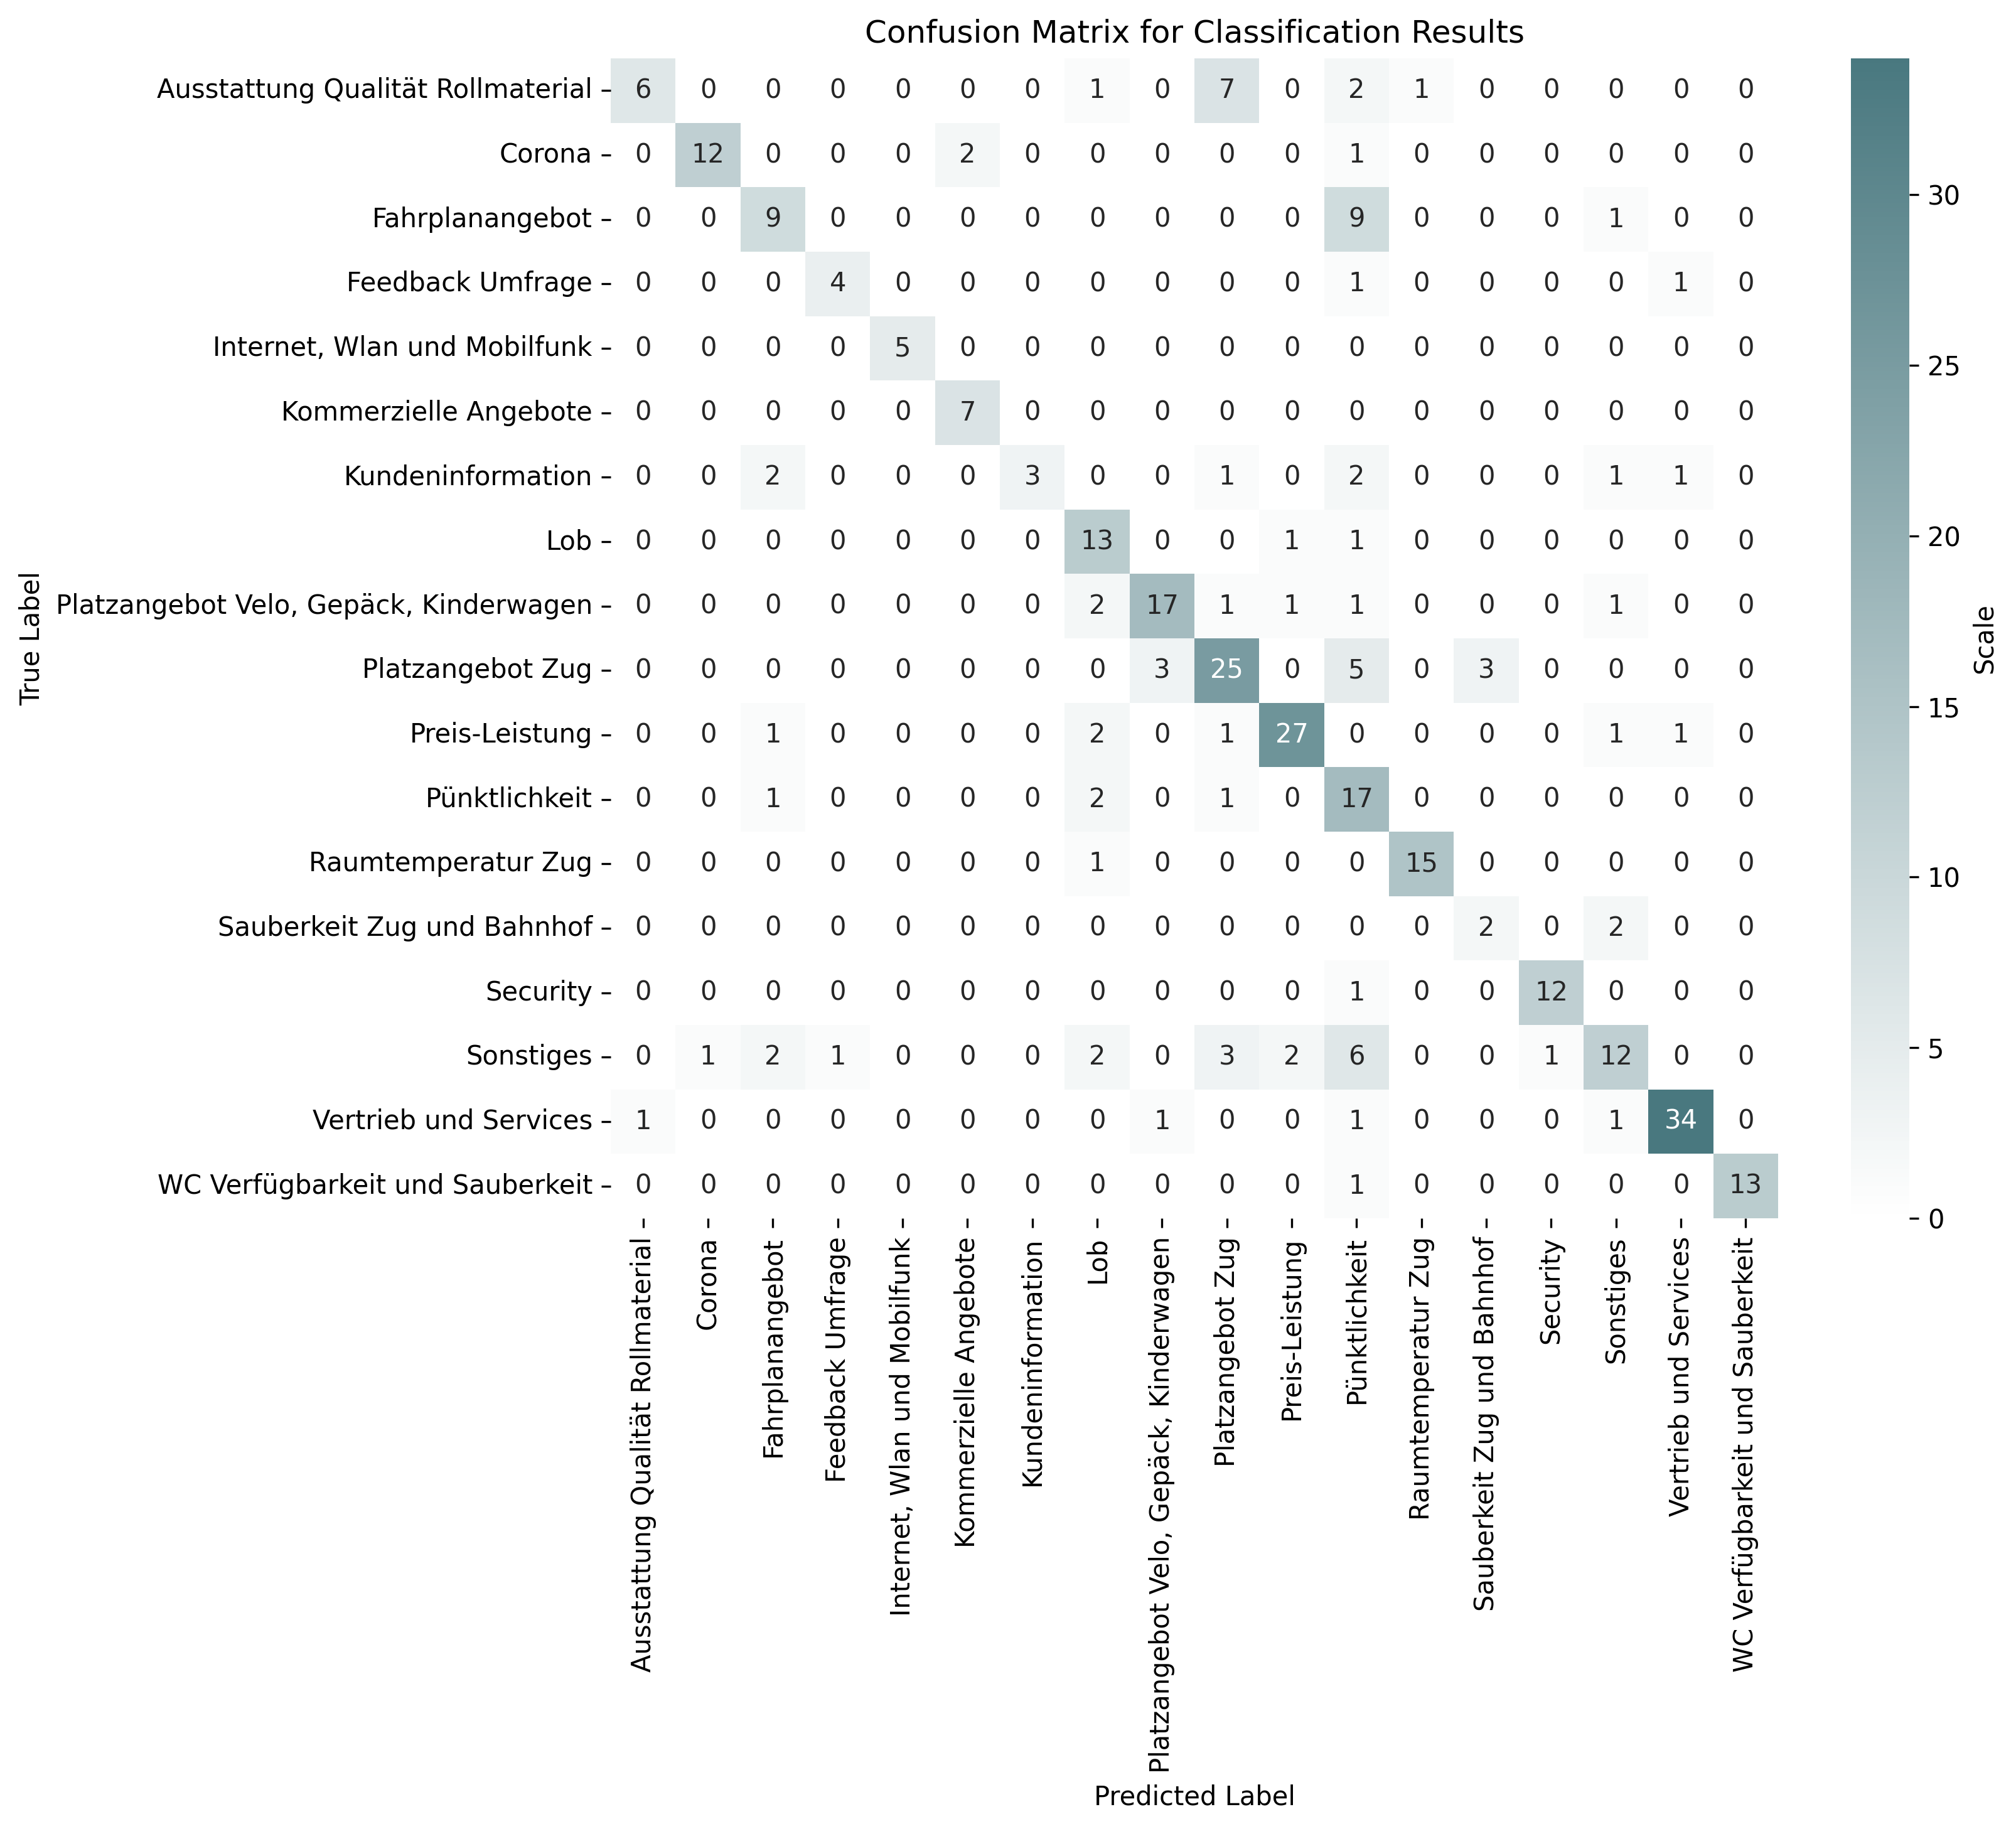

                                        precision    recall  f1-score   support

     Ausstattung Qualität Rollmaterial       0.86      0.35      0.50        17
                                Corona       0.92      0.80      0.86        15
                       Fahrplanangebot       0.60      0.47      0.53        19
                      Feedback Umfrage       0.80      0.67      0.73         6
          Internet, Wlan und Mobilfunk       1.00      1.00      1.00         5
                 Kommerzielle Angebote       0.78      1.00      0.88         7
                     Kundeninformation       1.00      0.30      0.46        10
                                   Lob       0.57      0.87      0.68        15
Platzangebot Velo, Gepäck, Kinderwagen       0.81      0.74      0.77        23
                      Platzangebot Zug       0.64      0.69      0.67        36
                        Preis-Leistung       0.87      0.82      0.84        33
                         Pünktlichkeit 

In [92]:
plot_confusion_matrix(df,
                      predicted_col='predicted_topic',
                      actual_col='real_topic',
                      path=path,
                      filename="Confusion_Matrix_CLassification_Model_2")